BoF is one of the popular visual descriptors used for visual data classification. BoF is inspired by a concept called Bag of Words that is used in document classification. A bag of words is a sparse vector of occurrence counts of words; that is, a sparse histogram over the vocabulary. In computer vision, a bag of visual words of features is a sparse vector of occurrence counts of a vocabulary of local image features.

BoF typically involves in two main steps. First step is obtaining the set of bags of features. This step is actually an offline process. We can obtain set of bags for particular features and then use them for creating BoF descriptor. The second step is we cluster the set of given features into the set of bags that we created in first step and then create the histogram taking the bags as the bins. This histogram can be used to classify the image or video frame.

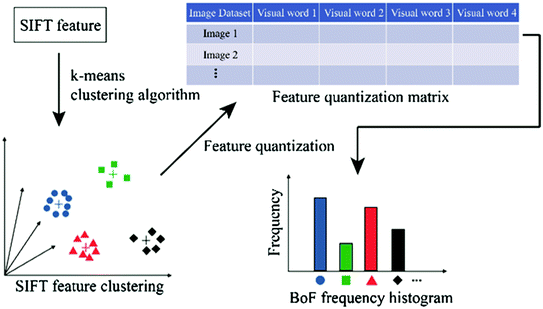


You can check my other notebooks:

- [Shopee Products Matching: Image Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-image-part-english)
- [Shopee Products Matching: Text Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-text-part-english)
- [Shopee Products Matching: BoF Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-bof-part-english)
- [Shopee Products Matching: Augment Part [English中文]](https://www.kaggle.com/finlay/shopee-products-matching-augment-part-english)
- [[Unsupervised] Image + Text Baseline in 20min](https://www.kaggle.com/finlay/unsupervised-image-text-baseline-in-20min)

In [ ]:
# DATA_PATH = '../input/'
DATA_PATH = '../input/shopee-product-matching/'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

In [ ]:
COMPUTE_CV = True

test = pd.read_csv(DATA_PATH + 'test.csv')
if len(test)>3: COMPUTE_CV = False
else: print('this submission notebook will compute CV score, but commit notebook will not')

# COMPUTE_CV = False

if COMPUTE_CV:
    train = pd.read_csv(DATA_PATH + 'train.csv')
    train['image'] = DATA_PATH + 'train_images/' + train['image']
    tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
    train['target'] = train.label_group.map(tmp)
#     train_gf = cudf.read_csv(DATA_PATH + 'train.csv')
else:
    train = pd.read_csv(DATA_PATH + 'test.csv')
    train['image'] = DATA_PATH + 'test_images/' + train['image']
#     train_gf = cudf.read_csv(DATA_PATH + 'test.csv')
    
print('train shape is', train.shape )
train.head()

In [ ]:
# cpu单核
def orb_det(path):
    orb = cv2.ORB_create(300)
    img = cv2.imread(path, 0)
    return orb.detectAndCompute(img, None)[1]

from joblib import Parallel, delayed, dump

In [ ]:
img_orbs = Parallel(n_jobs=2)(delayed(orb_det)(path) 
                for path in tqdm_notebook(train['image'].values[:1000]))

In [ ]:
img_orbs_feat = np.vstack(img_orbs)
img_orbs_feat.shape

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# 内存限制，
kmeans = MiniBatchKMeans(n_clusters=5000, random_state=0, batch_size=600)
kmeans = kmeans.fit(img_orbs_feat[:100000])

In [ ]:
from scipy.cluster.vq import vq

In [ ]:
img_orb_code_list = []
# 对每张图像，计算关键点最近的聚类中心
for img_orb in tqdm_notebook(img_orbs):
    img_orb_code = np.zeros(5000)
    idx = vq(img_orb, kmeans.cluster_centers_)[0]
    img_orb_code[idx] += 1
    
    img_orb_code_list.append(img_orb_code)

In [ ]:
img_orb_code_list = np.vstack(img_orb_code_list)

In [ ]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (img_orb_code_list > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_orb_code_list)+1) / (1.0*nbr_occurences + 1)), 'float32')

# Perform L2 normalization
im_features = img_orb_code_list*idf

from sklearn.preprocessing import normalize
im_features = normalize(im_features, norm='l2')